In [2]:
# Load selected variables from tensors.pkl and assign them with the same names
import os
import pickle
import numpy as np

FNAME = "tensors.pkl"
NEEDED_KEYS = ["tensorNEP_rewarded100pp",
    "tensorNEP_rewarded100hp",
    "tensorTE_filt_100pp",
    "tensorTE_filt_100hp",
    "tensorNEP_rewarded100pp_rewarded",
    "tensorNEP_rewarded100hp_rewarded",
    "tensorTE_filt_100pp_rewarded",
    "tensorTE_filt_100hp_rewarded",
    "event_arm_ids",
    "event_arm_ids_rewarded",]

if not os.path.exists(FNAME):
    raise FileNotFoundError(f"File not found: {FNAME}")

with open(FNAME, "rb") as f:
    data = pickle.load(f)

if not isinstance(data, dict):
    raise ValueError("Pickle content is not a dict of named objects.")

# load only necessary data (keep names)
missing = []
for k in NEEDED_KEYS:
    if k in data:
        globals()[k] = data[k]
    else:
        globals()[k] = None
        missing.append(k)

# brief summary for sanity check
def _brief(v):
    if isinstance(v, np.ndarray):
        return f"ndarray shape={v.shape}, dtype={v.dtype}"
    try:
        if hasattr(v, "shape") and v.shape is not None:
            return f"{type(v).__name__} shape={v.shape}"
        if hasattr(v, "__len__") and not isinstance(v, (str, bytes)):
            return f"{type(v).__name__} len={len(v)}"
    except Exception:
        pass
    return type(v).__name__

print(f"Loaded from {FNAME}:")
for k in NEEDED_KEYS:
    print(f"  • {k}: {_brief(globals()[k])}")

if missing:
    print("\n[warning] Missing key(s) in pickle:", ", ".join(missing))

Loaded from tensors.pkl:
  • tensorNEP_rewarded100pp: ndarray shape=(399, 133, 140), dtype=float32
  • tensorNEP_rewarded100hp: ndarray shape=(40, 133, 140), dtype=float32
  • tensorTE_filt_100pp: ndarray shape=(373, 64, 180), dtype=float64
  • tensorTE_filt_100hp: ndarray shape=(40, 64, 180), dtype=float64
  • tensorNEP_rewarded100pp_rewarded: NoneType
  • tensorNEP_rewarded100hp_rewarded: NoneType
  • tensorTE_filt_100pp_rewarded: ndarray shape=(373, 64, 133), dtype=float64
  • tensorTE_filt_100hp_rewarded: ndarray shape=(40, 64, 133), dtype=float64
  • event_arm_ids: list len=180
  • event_arm_ids_rewarded: ndarray shape=(133,), dtype=int64

[warning] Missing key(s) in pickle: tensorNEP_rewarded100pp_rewarded, tensorNEP_rewarded100hp_rewarded


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


# Apply TCA (PARAFAC) 

def apply_tca(tensor, rank=3):
    """
    Apply PARAFAC decomposition to a 3D tensor (neurons × events × positions).

    Steps:
    1. Reorder tensor to (events × neurons × positions) because trial mode must be first.
    2. Apply tensorly.parafac decomposition.
    3. Return the factor matrices: (trials, neurons, positions).

    Parameters
    ----------
    tensor_sorted : np.ndarray
        3D tensor (neurons × events × positions).
    rank : int
        Number of components to extract.

    Returns
    -------
    factors : tuple
        (trial_factors, neuron_factors, position_factors)
    """
    # Reorder to (events × neurons × positions)
    tensor_reordered = np.transpose(tensor, (1, 0, 2))

    # Apply PARAFAC decomposition
    tl_tensor = tl.tensor(tensor_reordered, dtype=np.float32)
    weights, factors = parafac(tl_tensor, rank=rank, init='random', tol=1e-6)

    return factors  # factors[0] -> trials, factors[1] -> neurons, factors[2] -> positions


# Plot TCA Components 

def plot_tca_components(factors, arm_sorted):
    """
    Plot the three factors (trials, neurons, positions) from PARAFAC decomposition.

    - Trials: Scatter plot colored by arm ID
    - Neurons: Bar plot
    - Positions: Line plot

    Parameters
    ----------
    factors : tuple
        Output of apply_tca() → (trial_factors, neuron_factors, position_factors)
    arm_sorted : np.ndarray
        Array of arm IDs for each event (sorted).
    """
    trial_factors, neuron_factors, position_factors = factors
    R = trial_factors.shape[1]

    # Define colors for arm IDs
    unique_arms = np.unique(arm_sorted)
    cmap = plt.get_cmap("tab10")
    arm_colors = [cmap(i % 10) for i in arm_sorted]

    for r in range(R):
        plt.figure(figsize=(10, 3))

        # Trial Factor (events)
        plt.subplot(1, 3, 1)
        plt.scatter(np.arange(len(arm_sorted)), trial_factors[:, r], c=arm_colors, s=20)
        plt.title(f"Trial Factor (Comp {r+1})")
        plt.xlabel("Events (sorted by arm ID)")
        plt.ylabel("Activation")

        # Neuron Factor
        plt.subplot(1, 3, 2)
        plt.bar(np.arange(neuron_factors.shape[0]), neuron_factors[:, r], color="gray")
        plt.title("Neuron Factor")
        plt.xlabel("Neuron index")
        plt.ylabel("Weight")

        # Position Factor
        plt.subplot(1, 3, 3)
        plt.plot(position_factors[:, r], color="blue", lw=2)
        plt.title("Position Factor")
        plt.xlabel("Position bin (0–140)")
        plt.ylabel("Weight")

        plt.tight_layout()
        plt.show()

In [4]:
def sort_events_and_tcafactors(factors, event_arm_ids):
# Order events and factors by arm ID order
  sort_idx = np.argsort(event_arm_ids)  
  factors[0] = factors[0][sort_idx]
  event_arm_ids_sorted = event_arm_ids[sort_idx]
  return factors, event_arm_ids_sorted

def plot_sorted_tca(factors, event_arm_ids):
    # Order events and factors by arm ID order
    factors_sorted, event_arm_ids_sorted = sort_events_and_tcafactors(factors, event_arm_ids)
    
    # Plots 
    plot_tca_components(factors_sorted, event_arm_ids_sorted)

    return factors_sorted, event_arm_ids_sorted

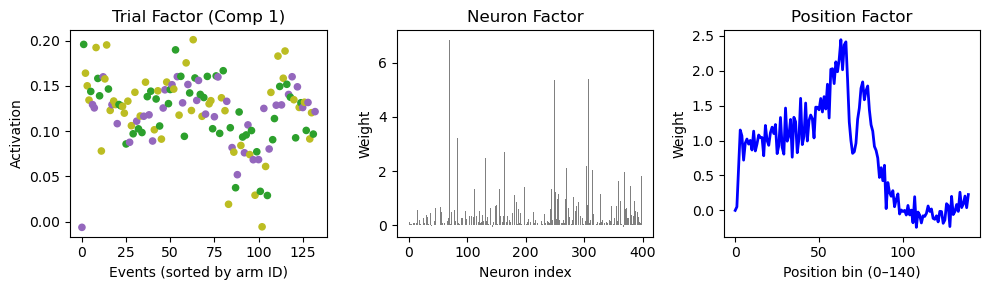

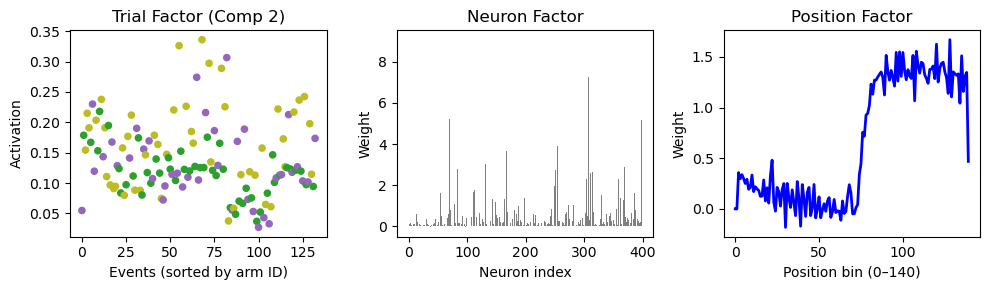

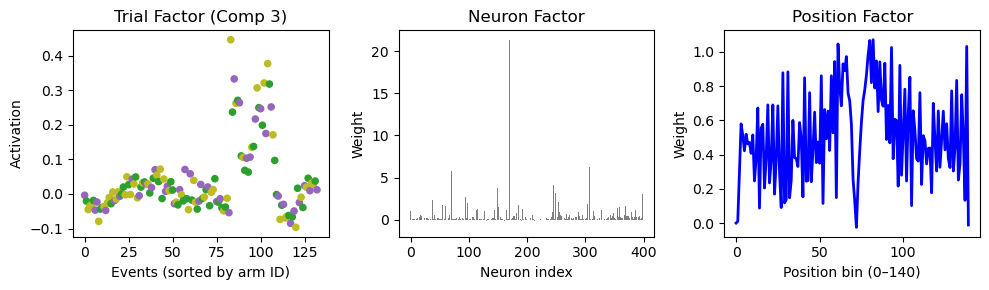

In [5]:
# Apply TCA
factors_NEP_rewarded100pp = apply_tca(tensorNEP_rewarded100pp, rank=3)

# Plot TCA (non-sorted)
plot_tca_components(factors_NEP_rewarded100pp, event_arm_ids_rewarded)

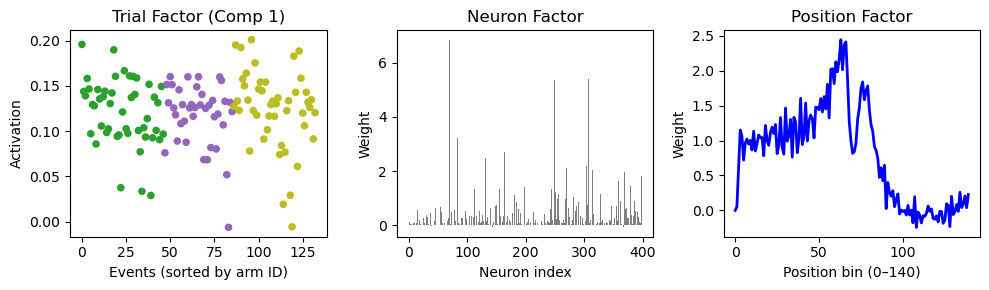

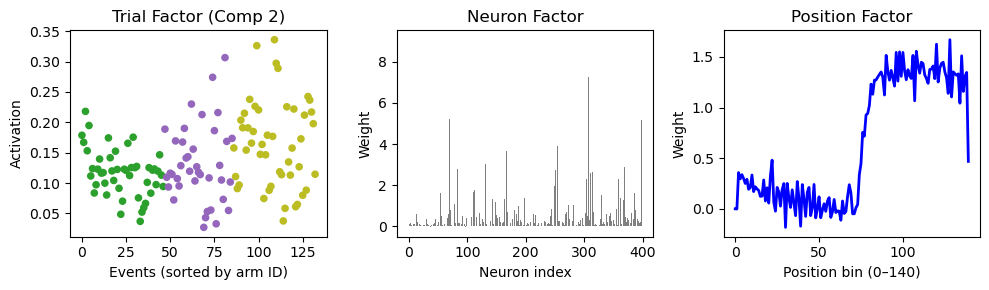

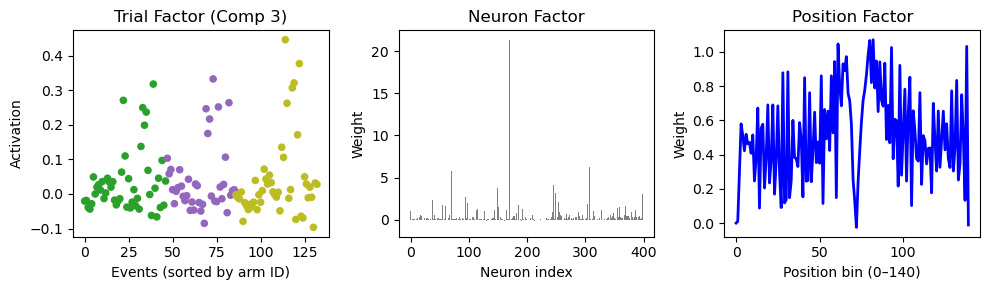

In [6]:
# Plot TCA (sorted)
factors_sorted, event_arm_ids_sorted = plot_sorted_tca(factors_NEP_rewarded100pp, event_arm_ids_rewarded)

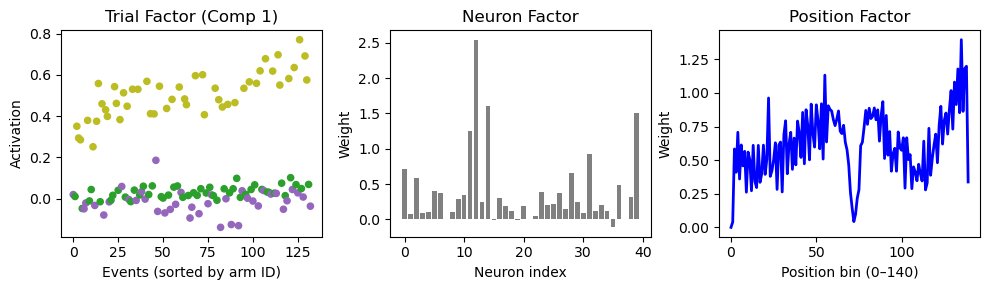

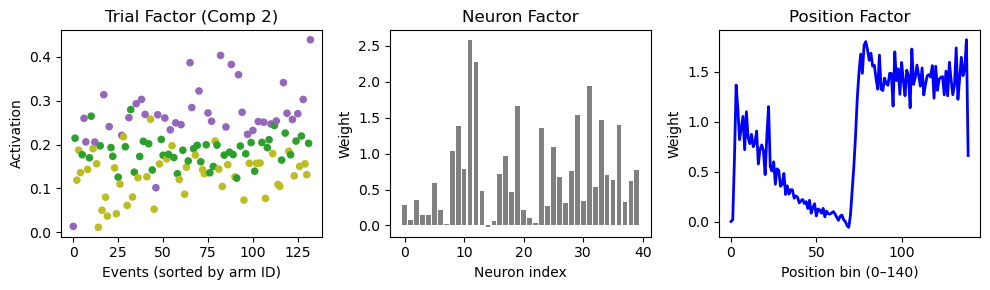

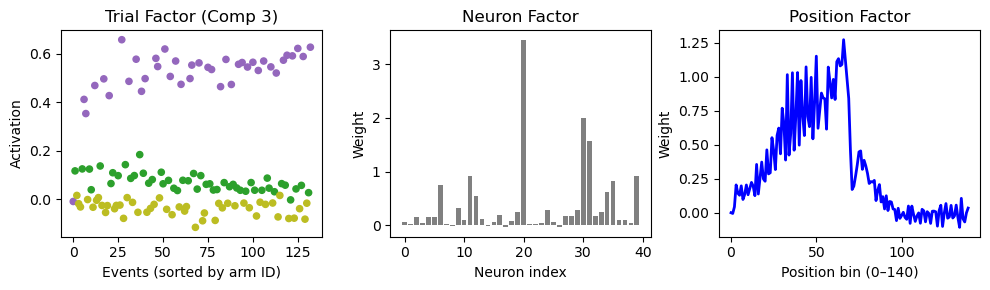

In [7]:
# Apply TCA
factors_NEP_rewarded100hp = apply_tca(tensorNEP_rewarded100hp, rank=3)

# Plot TCA (non-sorted)
plot_tca_components(factors_NEP_rewarded100hp, event_arm_ids_rewarded)

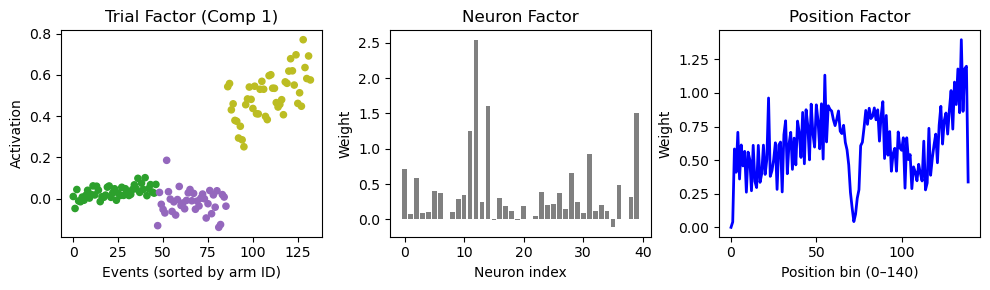

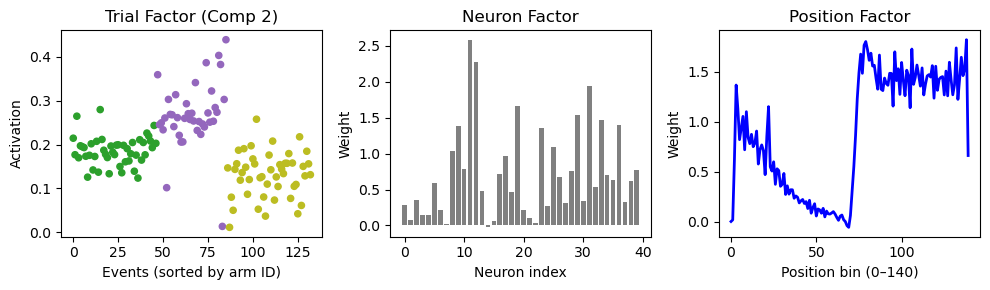

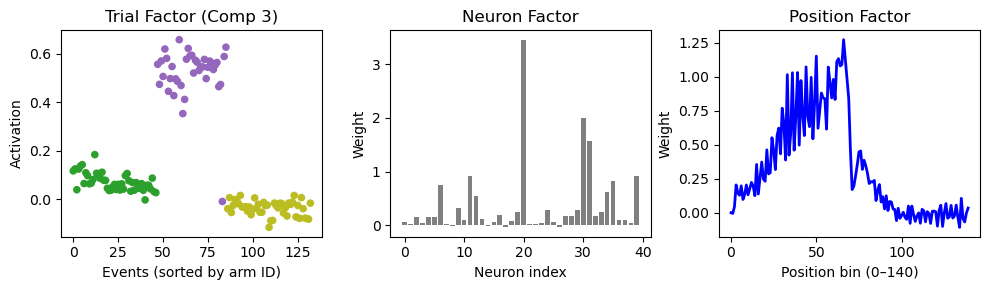

In [8]:
# Plot TCA (sorted)
factors_sorted, event_arm_ids_sorted = plot_sorted_tca(factors_NEP_rewarded100hp, event_arm_ids_rewarded)

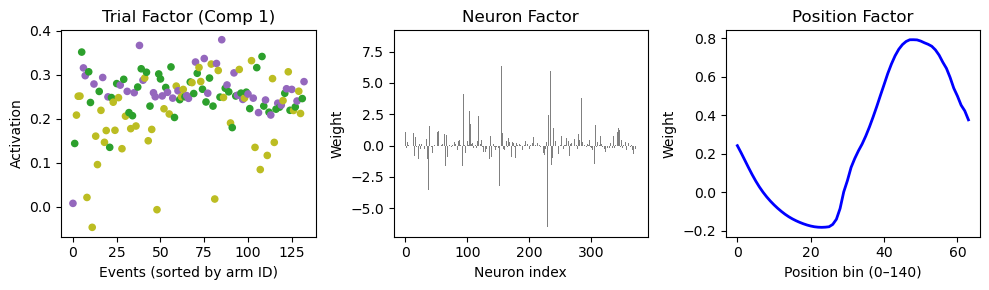

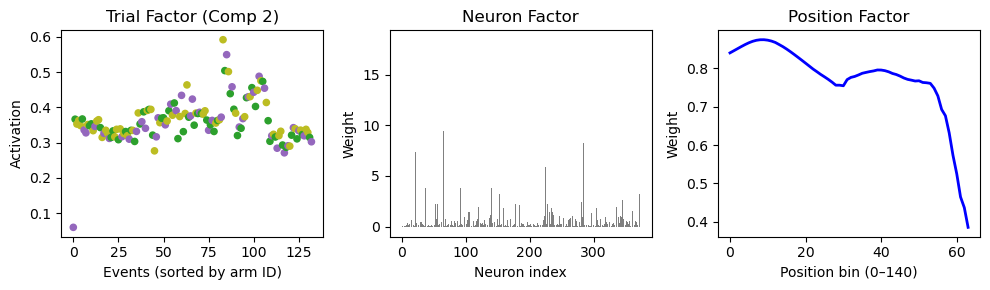

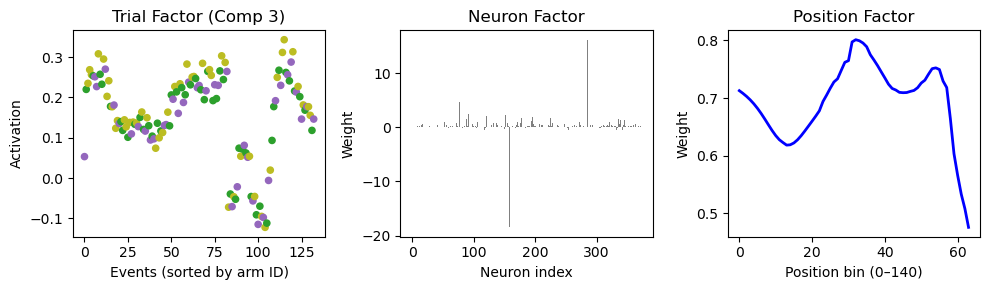

In [10]:
import numpy as np

# tensor shape (N, T, E)  ->  we want (N, E, T) for apply_TCA function
tensorTE_filt_100pp_rewarded = np.transpose(tensorTE_filt_100pp_rewarded, (0, 2, 1))   

# Apply TCA
factors_TE_filt_100pp_rewarded = apply_tca(tensorTE_filt_100pp_rewarded, rank=3)

# Plot TCA (non-sorted)
plot_tca_components(factors_TE_filt_100pp_rewarded, event_arm_ids_rewarded)

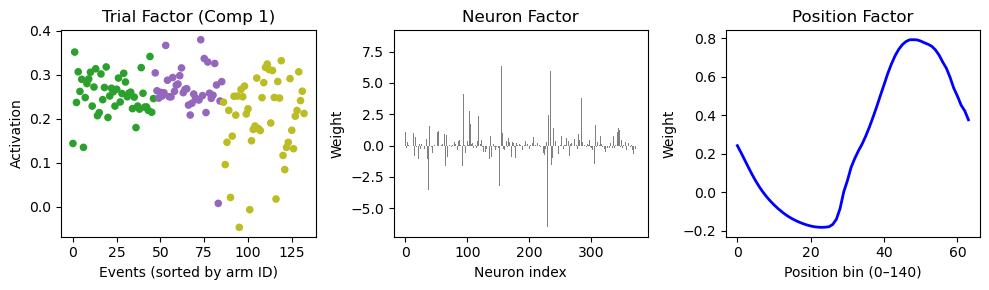

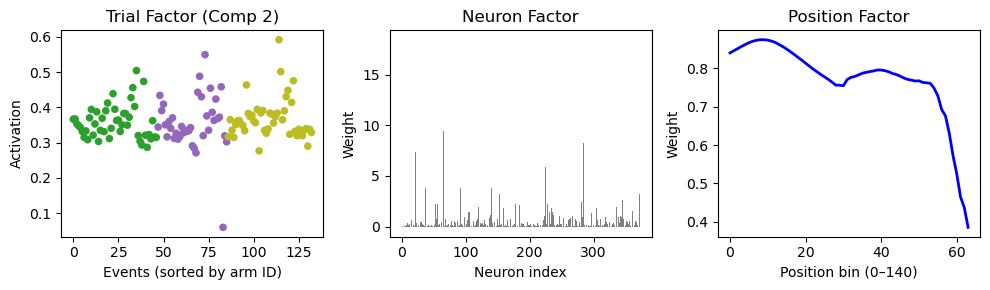

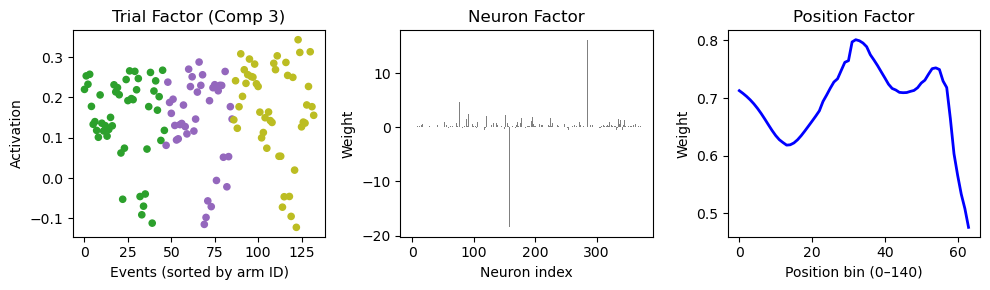

In [11]:
# Plot TCA (sorted)
factors_sorted, event_arm_ids_sorted = plot_sorted_tca(factors_TE_filt_100pp_rewarded, event_arm_ids_rewarded)

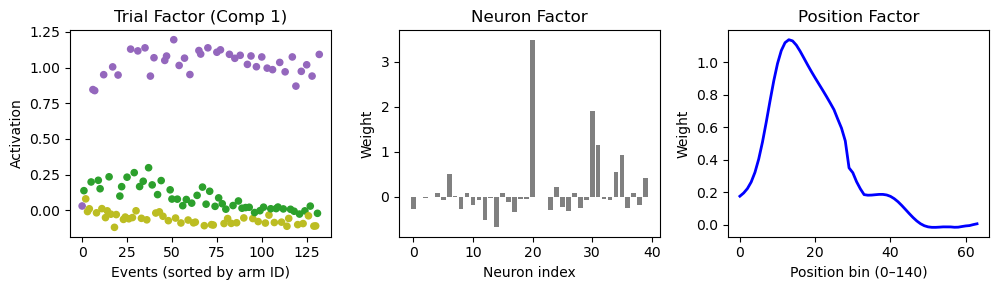

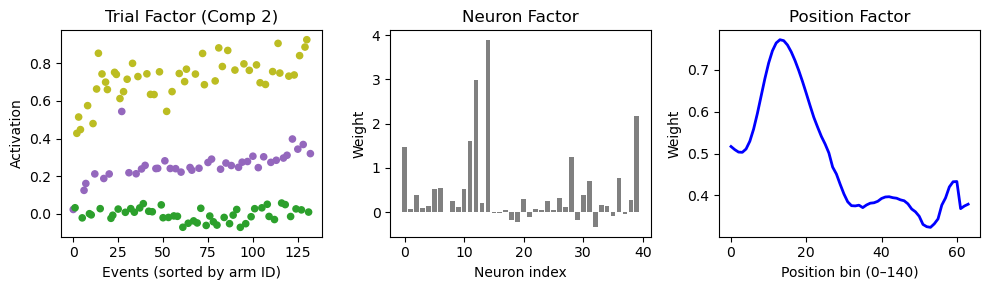

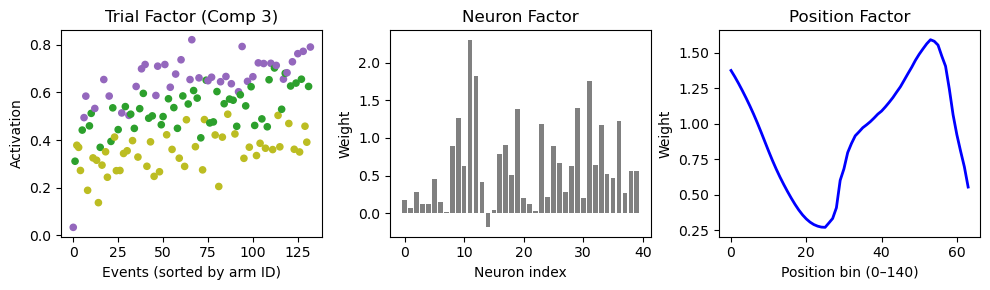

In [13]:
import numpy as np

# tensor shape (N, T, E)  ->  we want (N, E, T) for apply_TCA function
tensorTE_filt_100hp_rewarded = np.transpose(tensorTE_filt_100hp_rewarded, (0, 2, 1))   

# Apply TCA
factors_TE_filt_100hp_rewarded = apply_tca(tensorTE_filt_100hp_rewarded, rank=3)

# Plot TCA (non-sorted)
plot_tca_components(factors_TE_filt_100hp_rewarded, event_arm_ids_rewarded)

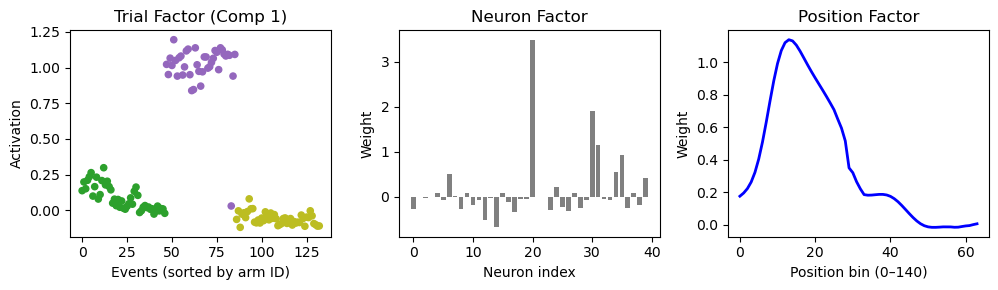

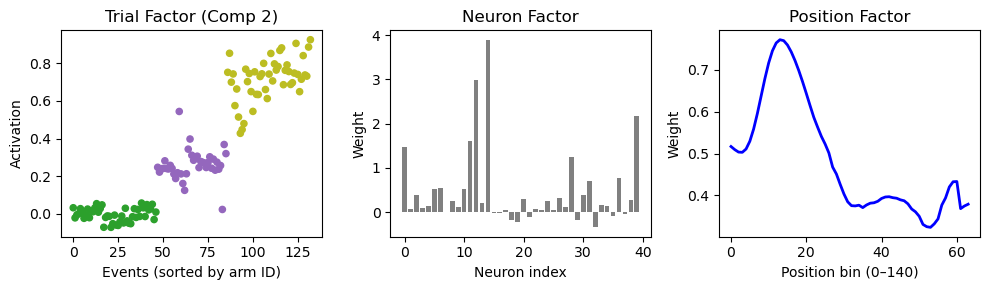

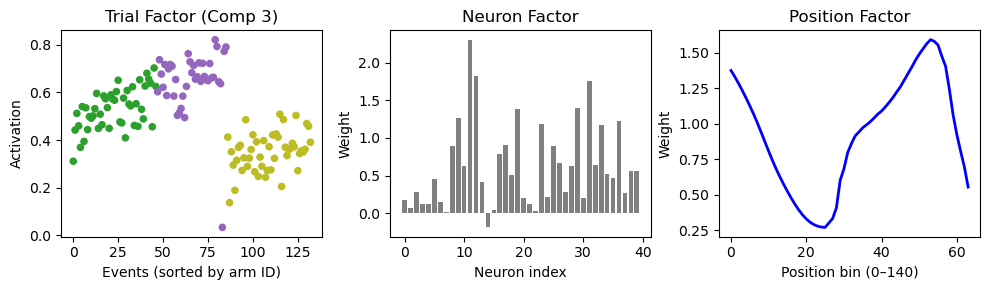

In [14]:
# Plot TCA (sorted)
factors_sorted, event_arm_ids_sorted = plot_sorted_tca(factors_TE_filt_100hp_rewarded, event_arm_ids_rewarded)